# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 7.35KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

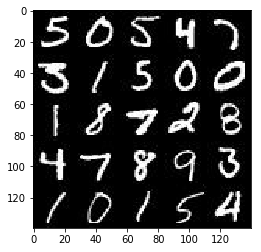

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

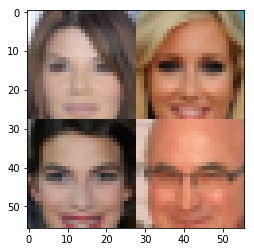

In [5]:
show_n_images = 4#25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [48]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, (None))
    
    return real_image, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [70]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    keep_prob = 0.6
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.nn.dropout(relu1, keep_prob=keep_prob)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
        
        
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [85]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # First fully connected layer
    alpha = 0.01
    keep_prob = 0.5
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        # 4x4x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 8x8x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # 16x16x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 32x32x3 now

        out = tf.tanh(logits)
    
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [86]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [87]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [88]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [89]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, out_channel_dim = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    print_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                               
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    d_train_loss = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_train_loss = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                            "Generator Loss: {:.4f}".format(g_train_loss),
                            "Discriminator Loss: {:.4f}...".format(d_train_loss))
                    # Save losses to view after training
                    losses.append((d_train_loss, g_train_loss))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
                
    return losses
                
                

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Generator Loss: 1.1802 Discriminator Loss: 0.9199...
Epoch 1/2... Generator Loss: 0.9686 Discriminator Loss: 0.7627...
Epoch 1/2... Generator Loss: 1.2053 Discriminator Loss: 1.0021...
Epoch 1/2... Generator Loss: 1.5310 Discriminator Loss: 1.4829...
Epoch 1/2... Generator Loss: 0.9193 Discriminator Loss: 1.2953...
Epoch 1/2... Generator Loss: 1.2960 Discriminator Loss: 1.4358...
Epoch 1/2... Generator Loss: 1.1444 Discriminator Loss: 1.1605...
Epoch 1/2... Generator Loss: 1.4624 Discriminator Loss: 0.9605...
Epoch 1/2... Generator Loss: 1.3529 Discriminator Loss: 1.0369...
Epoch 1/2... Generator Loss: 1.2189 Discriminator Loss: 1.0320...


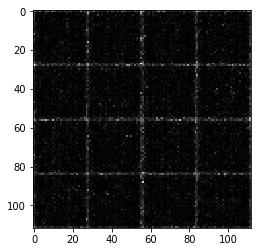

Epoch 1/2... Generator Loss: 1.0936 Discriminator Loss: 1.1827...
Epoch 1/2... Generator Loss: 1.4689 Discriminator Loss: 1.2036...
Epoch 1/2... Generator Loss: 1.5473 Discriminator Loss: 1.1440...
Epoch 1/2... Generator Loss: 1.2339 Discriminator Loss: 1.0619...
Epoch 1/2... Generator Loss: 1.0788 Discriminator Loss: 1.3376...
Epoch 1/2... Generator Loss: 1.4601 Discriminator Loss: 1.2034...
Epoch 1/2... Generator Loss: 1.0554 Discriminator Loss: 1.4681...
Epoch 1/2... Generator Loss: 0.8050 Discriminator Loss: 1.0671...
Epoch 1/2... Generator Loss: 0.9385 Discriminator Loss: 1.3659...
Epoch 1/2... Generator Loss: 1.4610 Discriminator Loss: 1.0061...


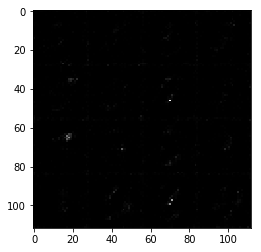

Epoch 1/2... Generator Loss: 1.0890 Discriminator Loss: 1.1294...
Epoch 1/2... Generator Loss: 1.1742 Discriminator Loss: 1.3756...
Epoch 1/2... Generator Loss: 1.2375 Discriminator Loss: 1.2613...
Epoch 1/2... Generator Loss: 1.3459 Discriminator Loss: 1.1613...
Epoch 1/2... Generator Loss: 1.0610 Discriminator Loss: 1.3437...
Epoch 1/2... Generator Loss: 1.4320 Discriminator Loss: 1.1696...
Epoch 1/2... Generator Loss: 1.3361 Discriminator Loss: 1.2089...
Epoch 1/2... Generator Loss: 1.4081 Discriminator Loss: 1.2002...
Epoch 1/2... Generator Loss: 1.3669 Discriminator Loss: 1.2635...
Epoch 1/2... Generator Loss: 1.1119 Discriminator Loss: 1.3226...


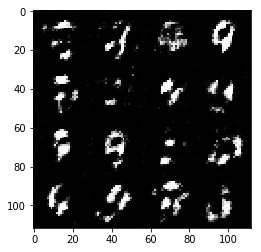

Epoch 1/2... Generator Loss: 1.0088 Discriminator Loss: 1.1099...
Epoch 1/2... Generator Loss: 0.8522 Discriminator Loss: 1.2741...
Epoch 1/2... Generator Loss: 1.2052 Discriminator Loss: 1.5914...
Epoch 1/2... Generator Loss: 1.2706 Discriminator Loss: 1.2502...
Epoch 1/2... Generator Loss: 1.2958 Discriminator Loss: 1.1722...
Epoch 1/2... Generator Loss: 1.2987 Discriminator Loss: 0.7340...
Epoch 1/2... Generator Loss: 1.4638 Discriminator Loss: 1.0532...
Epoch 1/2... Generator Loss: 1.7488 Discriminator Loss: 1.0907...
Epoch 1/2... Generator Loss: 1.2735 Discriminator Loss: 1.0432...
Epoch 1/2... Generator Loss: 1.0859 Discriminator Loss: 0.9342...


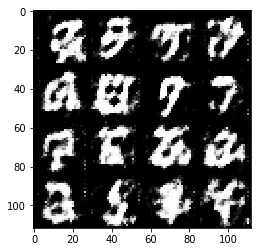

Epoch 1/2... Generator Loss: 1.7931 Discriminator Loss: 1.1075...
Epoch 1/2... Generator Loss: 1.5059 Discriminator Loss: 0.8266...
Epoch 1/2... Generator Loss: 1.3388 Discriminator Loss: 0.8673...
Epoch 1/2... Generator Loss: 1.6210 Discriminator Loss: 0.6727...
Epoch 1/2... Generator Loss: 0.9990 Discriminator Loss: 1.1153...
Epoch 1/2... Generator Loss: 0.7606 Discriminator Loss: 1.0428...
Epoch 1/2... Generator Loss: 1.0880 Discriminator Loss: 0.9388...
Epoch 1/2... Generator Loss: 1.2607 Discriminator Loss: 0.9061...
Epoch 1/2... Generator Loss: 1.1138 Discriminator Loss: 1.4217...
Epoch 1/2... Generator Loss: 1.2930 Discriminator Loss: 1.1545...


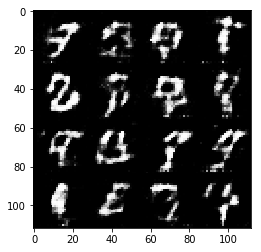

Epoch 1/2... Generator Loss: 0.9783 Discriminator Loss: 1.1269...
Epoch 1/2... Generator Loss: 1.2133 Discriminator Loss: 0.8515...
Epoch 1/2... Generator Loss: 1.3629 Discriminator Loss: 1.2224...
Epoch 1/2... Generator Loss: 1.2664 Discriminator Loss: 1.1174...
Epoch 1/2... Generator Loss: 1.0894 Discriminator Loss: 1.1353...
Epoch 1/2... Generator Loss: 1.3740 Discriminator Loss: 0.9943...
Epoch 1/2... Generator Loss: 1.1233 Discriminator Loss: 1.3269...
Epoch 1/2... Generator Loss: 1.1542 Discriminator Loss: 1.3649...
Epoch 1/2... Generator Loss: 1.5698 Discriminator Loss: 1.0053...
Epoch 1/2... Generator Loss: 1.2936 Discriminator Loss: 1.0407...


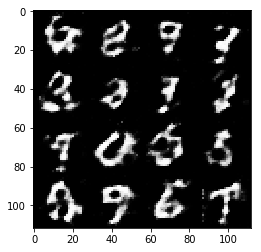

Epoch 1/2... Generator Loss: 1.4654 Discriminator Loss: 1.1049...
Epoch 1/2... Generator Loss: 1.1831 Discriminator Loss: 0.9877...
Epoch 1/2... Generator Loss: 1.3460 Discriminator Loss: 1.1962...
Epoch 1/2... Generator Loss: 1.0441 Discriminator Loss: 1.0142...
Epoch 1/2... Generator Loss: 0.9241 Discriminator Loss: 1.1499...
Epoch 1/2... Generator Loss: 1.5091 Discriminator Loss: 0.9170...
Epoch 1/2... Generator Loss: 1.1482 Discriminator Loss: 1.2193...
Epoch 1/2... Generator Loss: 1.6560 Discriminator Loss: 0.8074...
Epoch 1/2... Generator Loss: 1.7291 Discriminator Loss: 0.9859...
Epoch 1/2... Generator Loss: 0.9444 Discriminator Loss: 1.2008...


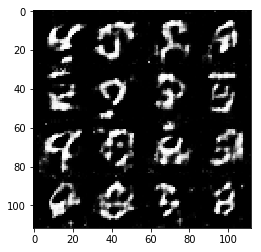

Epoch 1/2... Generator Loss: 1.5812 Discriminator Loss: 0.7948...
Epoch 1/2... Generator Loss: 1.0499 Discriminator Loss: 1.1599...
Epoch 1/2... Generator Loss: 1.2099 Discriminator Loss: 1.4022...
Epoch 1/2... Generator Loss: 0.9798 Discriminator Loss: 1.3736...
Epoch 1/2... Generator Loss: 1.5057 Discriminator Loss: 1.0314...
Epoch 1/2... Generator Loss: 1.7372 Discriminator Loss: 0.8193...
Epoch 1/2... Generator Loss: 1.3962 Discriminator Loss: 1.0516...
Epoch 1/2... Generator Loss: 0.8518 Discriminator Loss: 1.2621...
Epoch 1/2... Generator Loss: 1.9066 Discriminator Loss: 1.0933...
Epoch 1/2... Generator Loss: 0.7541 Discriminator Loss: 1.2431...


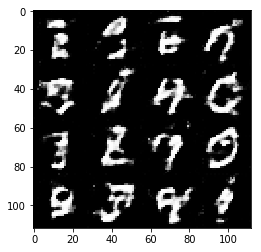

Epoch 1/2... Generator Loss: 1.0003 Discriminator Loss: 1.0491...
Epoch 1/2... Generator Loss: 1.6037 Discriminator Loss: 1.1657...
Epoch 1/2... Generator Loss: 1.2062 Discriminator Loss: 1.2662...
Epoch 1/2... Generator Loss: 1.2297 Discriminator Loss: 1.1804...
Epoch 1/2... Generator Loss: 1.4352 Discriminator Loss: 1.0282...
Epoch 1/2... Generator Loss: 0.6355 Discriminator Loss: 1.6108...
Epoch 1/2... Generator Loss: 1.1688 Discriminator Loss: 1.3681...
Epoch 1/2... Generator Loss: 1.3340 Discriminator Loss: 1.2092...
Epoch 1/2... Generator Loss: 1.0548 Discriminator Loss: 1.0203...
Epoch 1/2... Generator Loss: 0.9528 Discriminator Loss: 1.4315...


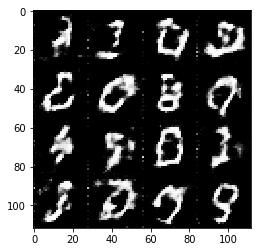

Epoch 1/2... Generator Loss: 1.3651 Discriminator Loss: 0.8212...
Epoch 1/2... Generator Loss: 0.9891 Discriminator Loss: 0.9836...
Epoch 1/2... Generator Loss: 1.2420 Discriminator Loss: 1.5266...
Epoch 1/2... Generator Loss: 1.3755 Discriminator Loss: 1.0697...
Epoch 1/2... Generator Loss: 1.3805 Discriminator Loss: 1.0028...
Epoch 1/2... Generator Loss: 1.3483 Discriminator Loss: 0.7746...
Epoch 1/2... Generator Loss: 1.4119 Discriminator Loss: 1.1999...
Epoch 1/2... Generator Loss: 1.2744 Discriminator Loss: 1.3228...
Epoch 1/2... Generator Loss: 1.2650 Discriminator Loss: 1.0764...
Epoch 1/2... Generator Loss: 1.0777 Discriminator Loss: 1.5126...


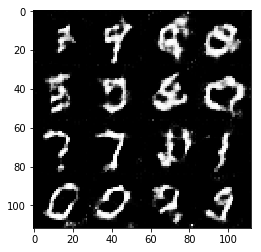

Epoch 1/2... Generator Loss: 1.0059 Discriminator Loss: 1.1063...
Epoch 1/2... Generator Loss: 0.8772 Discriminator Loss: 1.3181...
Epoch 1/2... Generator Loss: 0.8049 Discriminator Loss: 1.1483...
Epoch 1/2... Generator Loss: 1.2186 Discriminator Loss: 1.1051...
Epoch 1/2... Generator Loss: 1.1308 Discriminator Loss: 1.3516...
Epoch 1/2... Generator Loss: 1.7359 Discriminator Loss: 0.9521...
Epoch 1/2... Generator Loss: 1.0495 Discriminator Loss: 1.2507...
Epoch 1/2... Generator Loss: 0.9741 Discriminator Loss: 1.0152...
Epoch 1/2... Generator Loss: 1.3524 Discriminator Loss: 1.1236...
Epoch 1/2... Generator Loss: 1.0558 Discriminator Loss: 1.2630...


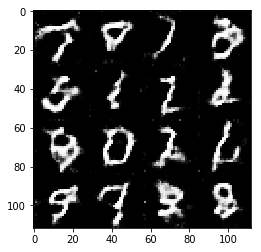

Epoch 1/2... Generator Loss: 1.6956 Discriminator Loss: 1.1646...
Epoch 1/2... Generator Loss: 1.4359 Discriminator Loss: 1.3192...
Epoch 1/2... Generator Loss: 1.1256 Discriminator Loss: 0.8977...
Epoch 1/2... Generator Loss: 1.2008 Discriminator Loss: 1.1357...
Epoch 1/2... Generator Loss: 1.1038 Discriminator Loss: 1.1983...
Epoch 1/2... Generator Loss: 1.2911 Discriminator Loss: 1.0061...
Epoch 1/2... Generator Loss: 0.8763 Discriminator Loss: 1.1482...
Epoch 1/2... Generator Loss: 0.8390 Discriminator Loss: 1.2389...
Epoch 1/2... Generator Loss: 1.2207 Discriminator Loss: 1.0528...
Epoch 1/2... Generator Loss: 1.0148 Discriminator Loss: 0.9759...


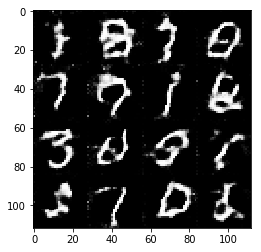

Epoch 1/2... Generator Loss: 0.9431 Discriminator Loss: 1.2805...
Epoch 1/2... Generator Loss: 0.9282 Discriminator Loss: 1.0671...
Epoch 1/2... Generator Loss: 1.2869 Discriminator Loss: 1.3951...
Epoch 1/2... Generator Loss: 0.8079 Discriminator Loss: 1.1592...
Epoch 1/2... Generator Loss: 1.2162 Discriminator Loss: 1.4937...
Epoch 1/2... Generator Loss: 0.8422 Discriminator Loss: 1.2694...
Epoch 1/2... Generator Loss: 1.0783 Discriminator Loss: 1.1130...
Epoch 1/2... Generator Loss: 1.1859 Discriminator Loss: 1.2808...
Epoch 1/2... Generator Loss: 1.0103 Discriminator Loss: 1.2061...
Epoch 1/2... Generator Loss: 1.4927 Discriminator Loss: 1.2181...


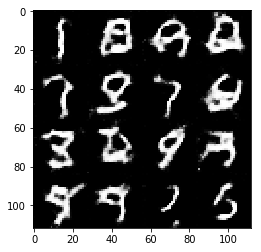

Epoch 1/2... Generator Loss: 0.7952 Discriminator Loss: 1.1441...
Epoch 1/2... Generator Loss: 1.3558 Discriminator Loss: 1.6008...
Epoch 1/2... Generator Loss: 0.6207 Discriminator Loss: 1.2809...
Epoch 1/2... Generator Loss: 1.1040 Discriminator Loss: 1.1948...
Epoch 1/2... Generator Loss: 0.7380 Discriminator Loss: 1.2051...
Epoch 1/2... Generator Loss: 1.1066 Discriminator Loss: 1.2377...
Epoch 1/2... Generator Loss: 1.6157 Discriminator Loss: 0.8949...
Epoch 1/2... Generator Loss: 1.0313 Discriminator Loss: 1.1753...
Epoch 1/2... Generator Loss: 0.9202 Discriminator Loss: 0.9153...
Epoch 1/2... Generator Loss: 0.9319 Discriminator Loss: 1.1964...


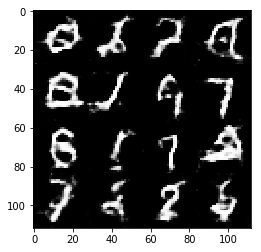

Epoch 1/2... Generator Loss: 0.9996 Discriminator Loss: 1.4044...
Epoch 1/2... Generator Loss: 1.4315 Discriminator Loss: 1.1534...
Epoch 1/2... Generator Loss: 1.1114 Discriminator Loss: 1.3364...
Epoch 1/2... Generator Loss: 1.6484 Discriminator Loss: 1.1713...
Epoch 1/2... Generator Loss: 1.0831 Discriminator Loss: 1.1805...
Epoch 1/2... Generator Loss: 1.1636 Discriminator Loss: 1.1589...
Epoch 1/2... Generator Loss: 1.1764 Discriminator Loss: 1.3018...
Epoch 1/2... Generator Loss: 0.6796 Discriminator Loss: 1.3612...
Epoch 1/2... Generator Loss: 0.9603 Discriminator Loss: 1.2619...
Epoch 1/2... Generator Loss: 1.1050 Discriminator Loss: 1.2300...


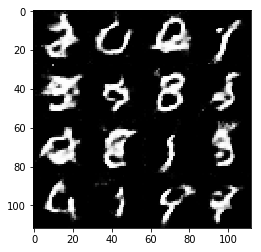

Epoch 1/2... Generator Loss: 1.1202 Discriminator Loss: 1.1983...
Epoch 1/2... Generator Loss: 1.0048 Discriminator Loss: 1.6434...
Epoch 1/2... Generator Loss: 0.8829 Discriminator Loss: 1.1811...
Epoch 1/2... Generator Loss: 1.1934 Discriminator Loss: 1.2390...
Epoch 1/2... Generator Loss: 1.0152 Discriminator Loss: 1.4223...
Epoch 1/2... Generator Loss: 0.7996 Discriminator Loss: 1.1446...
Epoch 1/2... Generator Loss: 0.9579 Discriminator Loss: 0.9191...
Epoch 1/2... Generator Loss: 1.3424 Discriminator Loss: 1.6562...
Epoch 1/2... Generator Loss: 0.7248 Discriminator Loss: 1.4987...
Epoch 1/2... Generator Loss: 0.8161 Discriminator Loss: 1.3643...


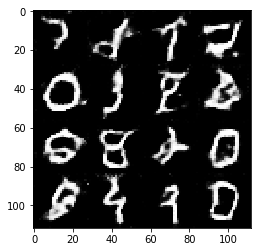

Epoch 1/2... Generator Loss: 1.0049 Discriminator Loss: 1.2693...
Epoch 1/2... Generator Loss: 1.0375 Discriminator Loss: 1.1361...
Epoch 1/2... Generator Loss: 0.8724 Discriminator Loss: 1.0672...
Epoch 1/2... Generator Loss: 0.8372 Discriminator Loss: 1.1281...
Epoch 1/2... Generator Loss: 0.9171 Discriminator Loss: 1.1913...
Epoch 1/2... Generator Loss: 0.9742 Discriminator Loss: 1.4630...
Epoch 1/2... Generator Loss: 0.8849 Discriminator Loss: 1.3136...
Epoch 1/2... Generator Loss: 0.9265 Discriminator Loss: 1.3526...
Epoch 1/2... Generator Loss: 1.1026 Discriminator Loss: 1.1776...
Epoch 1/2... Generator Loss: 1.3197 Discriminator Loss: 1.2324...


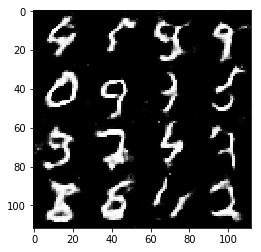

Epoch 1/2... Generator Loss: 1.0977 Discriminator Loss: 1.1509...
Epoch 1/2... Generator Loss: 1.1011 Discriminator Loss: 1.2682...
Epoch 1/2... Generator Loss: 1.1499 Discriminator Loss: 1.3319...
Epoch 1/2... Generator Loss: 1.0808 Discriminator Loss: 1.2605...
Epoch 1/2... Generator Loss: 0.8986 Discriminator Loss: 1.3679...
Epoch 1/2... Generator Loss: 0.9688 Discriminator Loss: 1.2778...
Epoch 1/2... Generator Loss: 1.0399 Discriminator Loss: 1.2242...
Epoch 1/2... Generator Loss: 1.2696 Discriminator Loss: 1.3429...
Epoch 1/2... Generator Loss: 1.0585 Discriminator Loss: 1.5822...
Epoch 1/2... Generator Loss: 1.0994 Discriminator Loss: 1.1161...


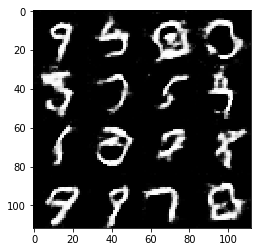

Epoch 1/2... Generator Loss: 0.5415 Discriminator Loss: 1.2102...
Epoch 1/2... Generator Loss: 0.9696 Discriminator Loss: 1.1434...
Epoch 1/2... Generator Loss: 0.8861 Discriminator Loss: 1.2782...
Epoch 1/2... Generator Loss: 0.8254 Discriminator Loss: 1.4169...
Epoch 1/2... Generator Loss: 0.6912 Discriminator Loss: 1.3789...
Epoch 1/2... Generator Loss: 1.2462 Discriminator Loss: 1.2564...
Epoch 1/2... Generator Loss: 0.9798 Discriminator Loss: 1.1123...
Epoch 2/2... Generator Loss: 0.9766 Discriminator Loss: 1.2864...
Epoch 2/2... Generator Loss: 0.9081 Discriminator Loss: 1.1940...
Epoch 2/2... Generator Loss: 1.1043 Discriminator Loss: 1.1211...


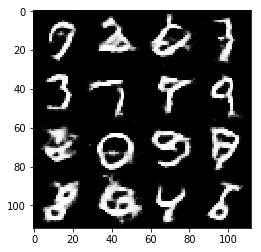

Epoch 2/2... Generator Loss: 0.9874 Discriminator Loss: 1.3619...
Epoch 2/2... Generator Loss: 0.9454 Discriminator Loss: 1.2132...
Epoch 2/2... Generator Loss: 1.3066 Discriminator Loss: 0.9011...
Epoch 2/2... Generator Loss: 0.8974 Discriminator Loss: 1.1186...
Epoch 2/2... Generator Loss: 0.8850 Discriminator Loss: 1.1554...
Epoch 2/2... Generator Loss: 0.7144 Discriminator Loss: 1.5908...
Epoch 2/2... Generator Loss: 0.9434 Discriminator Loss: 1.1887...
Epoch 2/2... Generator Loss: 1.2814 Discriminator Loss: 1.4490...
Epoch 2/2... Generator Loss: 1.1650 Discriminator Loss: 0.8966...
Epoch 2/2... Generator Loss: 1.0201 Discriminator Loss: 1.2640...


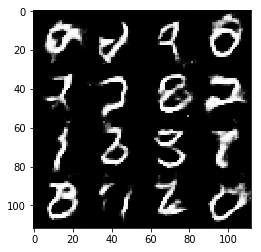

Epoch 2/2... Generator Loss: 1.1267 Discriminator Loss: 1.3199...
Epoch 2/2... Generator Loss: 0.8469 Discriminator Loss: 1.1697...
Epoch 2/2... Generator Loss: 0.9717 Discriminator Loss: 1.2317...
Epoch 2/2... Generator Loss: 1.1694 Discriminator Loss: 1.4844...
Epoch 2/2... Generator Loss: 0.8399 Discriminator Loss: 1.4475...
Epoch 2/2... Generator Loss: 1.1023 Discriminator Loss: 1.2801...
Epoch 2/2... Generator Loss: 0.7037 Discriminator Loss: 1.2717...
Epoch 2/2... Generator Loss: 0.9237 Discriminator Loss: 1.3090...
Epoch 2/2... Generator Loss: 1.2369 Discriminator Loss: 1.3774...
Epoch 2/2... Generator Loss: 1.4805 Discriminator Loss: 1.3371...


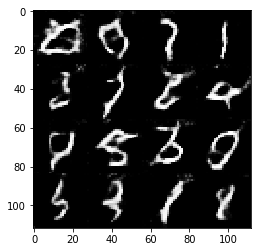

Epoch 2/2... Generator Loss: 1.2234 Discriminator Loss: 1.0846...
Epoch 2/2... Generator Loss: 1.0373 Discriminator Loss: 1.2982...
Epoch 2/2... Generator Loss: 1.3209 Discriminator Loss: 1.0075...
Epoch 2/2... Generator Loss: 1.0942 Discriminator Loss: 0.9845...
Epoch 2/2... Generator Loss: 1.1091 Discriminator Loss: 1.4025...
Epoch 2/2... Generator Loss: 0.7984 Discriminator Loss: 1.0638...
Epoch 2/2... Generator Loss: 0.8889 Discriminator Loss: 1.1060...
Epoch 2/2... Generator Loss: 0.7923 Discriminator Loss: 1.3004...
Epoch 2/2... Generator Loss: 1.3187 Discriminator Loss: 1.0463...
Epoch 2/2... Generator Loss: 1.0121 Discriminator Loss: 1.3347...


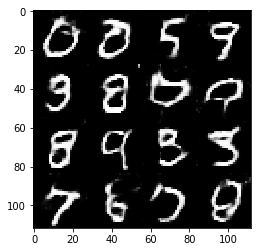

Epoch 2/2... Generator Loss: 0.5952 Discriminator Loss: 1.1614...
Epoch 2/2... Generator Loss: 0.9392 Discriminator Loss: 1.4228...
Epoch 2/2... Generator Loss: 0.9437 Discriminator Loss: 1.1433...
Epoch 2/2... Generator Loss: 0.9833 Discriminator Loss: 1.2497...
Epoch 2/2... Generator Loss: 0.9673 Discriminator Loss: 1.2086...
Epoch 2/2... Generator Loss: 1.0948 Discriminator Loss: 1.0028...
Epoch 2/2... Generator Loss: 1.1099 Discriminator Loss: 1.1877...
Epoch 2/2... Generator Loss: 0.8077 Discriminator Loss: 1.0593...
Epoch 2/2... Generator Loss: 0.6255 Discriminator Loss: 1.2761...
Epoch 2/2... Generator Loss: 0.8544 Discriminator Loss: 1.4396...


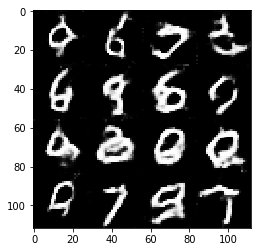

Epoch 2/2... Generator Loss: 1.1101 Discriminator Loss: 1.1277...
Epoch 2/2... Generator Loss: 0.8844 Discriminator Loss: 1.2512...
Epoch 2/2... Generator Loss: 1.0104 Discriminator Loss: 1.3425...
Epoch 2/2... Generator Loss: 0.7926 Discriminator Loss: 1.2878...
Epoch 2/2... Generator Loss: 0.9859 Discriminator Loss: 1.3517...
Epoch 2/2... Generator Loss: 1.2247 Discriminator Loss: 1.1413...
Epoch 2/2... Generator Loss: 1.0588 Discriminator Loss: 1.1438...
Epoch 2/2... Generator Loss: 1.1231 Discriminator Loss: 1.2518...
Epoch 2/2... Generator Loss: 1.3136 Discriminator Loss: 1.1719...
Epoch 2/2... Generator Loss: 0.9012 Discriminator Loss: 1.1951...


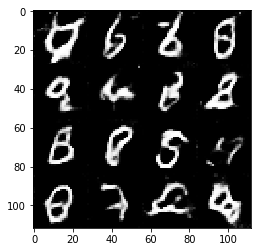

Epoch 2/2... Generator Loss: 1.1212 Discriminator Loss: 1.2038...
Epoch 2/2... Generator Loss: 1.0516 Discriminator Loss: 1.2564...
Epoch 2/2... Generator Loss: 1.0317 Discriminator Loss: 0.9861...
Epoch 2/2... Generator Loss: 1.0966 Discriminator Loss: 0.8730...
Epoch 2/2... Generator Loss: 0.7868 Discriminator Loss: 1.2970...
Epoch 2/2... Generator Loss: 0.8989 Discriminator Loss: 1.2616...
Epoch 2/2... Generator Loss: 1.1455 Discriminator Loss: 1.2728...
Epoch 2/2... Generator Loss: 1.0569 Discriminator Loss: 1.1429...
Epoch 2/2... Generator Loss: 0.8235 Discriminator Loss: 1.1641...
Epoch 2/2... Generator Loss: 1.1041 Discriminator Loss: 1.3022...


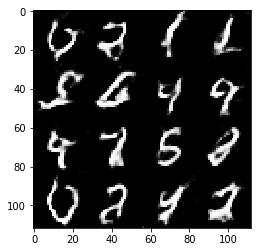

Epoch 2/2... Generator Loss: 0.9247 Discriminator Loss: 1.1625...
Epoch 2/2... Generator Loss: 1.0965 Discriminator Loss: 1.2637...
Epoch 2/2... Generator Loss: 1.1555 Discriminator Loss: 0.9919...
Epoch 2/2... Generator Loss: 0.8122 Discriminator Loss: 1.3115...
Epoch 2/2... Generator Loss: 1.3154 Discriminator Loss: 1.1706...
Epoch 2/2... Generator Loss: 1.0215 Discriminator Loss: 1.4064...
Epoch 2/2... Generator Loss: 1.0997 Discriminator Loss: 1.3591...
Epoch 2/2... Generator Loss: 1.0622 Discriminator Loss: 1.3318...
Epoch 2/2... Generator Loss: 1.1988 Discriminator Loss: 1.2242...
Epoch 2/2... Generator Loss: 1.1340 Discriminator Loss: 1.2071...


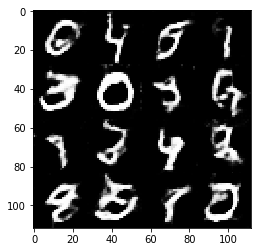

Epoch 2/2... Generator Loss: 1.0931 Discriminator Loss: 0.9200...
Epoch 2/2... Generator Loss: 1.1616 Discriminator Loss: 1.0379...
Epoch 2/2... Generator Loss: 1.0492 Discriminator Loss: 1.0916...
Epoch 2/2... Generator Loss: 0.6289 Discriminator Loss: 1.2717...
Epoch 2/2... Generator Loss: 1.1241 Discriminator Loss: 1.0453...
Epoch 2/2... Generator Loss: 0.6172 Discriminator Loss: 1.3903...
Epoch 2/2... Generator Loss: 0.5603 Discriminator Loss: 1.6650...
Epoch 2/2... Generator Loss: 1.0326 Discriminator Loss: 1.1346...
Epoch 2/2... Generator Loss: 0.9117 Discriminator Loss: 1.3429...
Epoch 2/2... Generator Loss: 0.8071 Discriminator Loss: 1.1818...


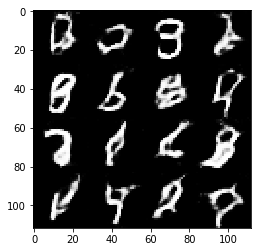

Epoch 2/2... Generator Loss: 1.1651 Discriminator Loss: 0.9840...
Epoch 2/2... Generator Loss: 1.0802 Discriminator Loss: 1.3955...
Epoch 2/2... Generator Loss: 1.1226 Discriminator Loss: 1.3607...
Epoch 2/2... Generator Loss: 0.8823 Discriminator Loss: 1.4247...
Epoch 2/2... Generator Loss: 1.1778 Discriminator Loss: 1.1696...
Epoch 2/2... Generator Loss: 1.0718 Discriminator Loss: 1.1162...
Epoch 2/2... Generator Loss: 0.6734 Discriminator Loss: 1.2029...
Epoch 2/2... Generator Loss: 0.8050 Discriminator Loss: 1.5243...
Epoch 2/2... Generator Loss: 0.7960 Discriminator Loss: 1.4684...
Epoch 2/2... Generator Loss: 0.9055 Discriminator Loss: 1.1922...


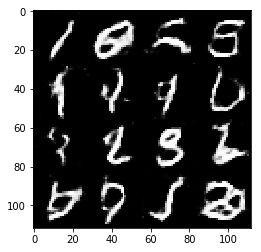

Epoch 2/2... Generator Loss: 1.0783 Discriminator Loss: 1.1798...
Epoch 2/2... Generator Loss: 0.8692 Discriminator Loss: 1.4507...
Epoch 2/2... Generator Loss: 0.9815 Discriminator Loss: 1.3335...
Epoch 2/2... Generator Loss: 0.9067 Discriminator Loss: 1.4751...
Epoch 2/2... Generator Loss: 0.7004 Discriminator Loss: 1.2938...
Epoch 2/2... Generator Loss: 1.4513 Discriminator Loss: 1.4274...
Epoch 2/2... Generator Loss: 0.7286 Discriminator Loss: 1.0924...
Epoch 2/2... Generator Loss: 0.9559 Discriminator Loss: 1.2297...
Epoch 2/2... Generator Loss: 1.1706 Discriminator Loss: 1.1758...
Epoch 2/2... Generator Loss: 0.9988 Discriminator Loss: 1.2769...


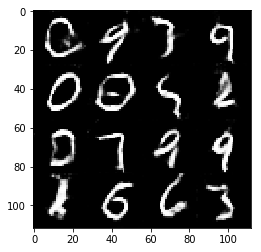

Epoch 2/2... Generator Loss: 1.0817 Discriminator Loss: 1.6687...
Epoch 2/2... Generator Loss: 0.6333 Discriminator Loss: 1.3033...
Epoch 2/2... Generator Loss: 0.9703 Discriminator Loss: 1.1572...
Epoch 2/2... Generator Loss: 0.9156 Discriminator Loss: 1.1078...
Epoch 2/2... Generator Loss: 0.9673 Discriminator Loss: 0.9337...
Epoch 2/2... Generator Loss: 1.1576 Discriminator Loss: 1.0437...
Epoch 2/2... Generator Loss: 1.0330 Discriminator Loss: 1.0902...
Epoch 2/2... Generator Loss: 0.8647 Discriminator Loss: 1.3586...
Epoch 2/2... Generator Loss: 0.9937 Discriminator Loss: 1.2034...
Epoch 2/2... Generator Loss: 0.9338 Discriminator Loss: 1.5348...


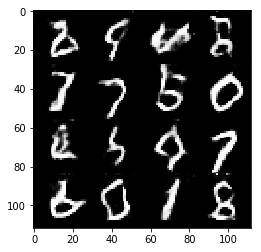

Epoch 2/2... Generator Loss: 0.8297 Discriminator Loss: 1.2960...
Epoch 2/2... Generator Loss: 1.2696 Discriminator Loss: 1.1113...
Epoch 2/2... Generator Loss: 1.0981 Discriminator Loss: 1.2976...
Epoch 2/2... Generator Loss: 0.9222 Discriminator Loss: 1.1773...
Epoch 2/2... Generator Loss: 1.1658 Discriminator Loss: 1.4712...
Epoch 2/2... Generator Loss: 0.9468 Discriminator Loss: 1.2516...
Epoch 2/2... Generator Loss: 1.0120 Discriminator Loss: 1.0323...
Epoch 2/2... Generator Loss: 1.1869 Discriminator Loss: 1.2391...
Epoch 2/2... Generator Loss: 0.7894 Discriminator Loss: 1.3427...
Epoch 2/2... Generator Loss: 0.8165 Discriminator Loss: 1.2205...


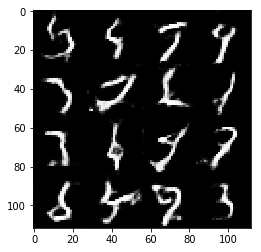

Epoch 2/2... Generator Loss: 1.0777 Discriminator Loss: 1.3157...
Epoch 2/2... Generator Loss: 0.8679 Discriminator Loss: 1.1732...
Epoch 2/2... Generator Loss: 1.2112 Discriminator Loss: 1.3970...
Epoch 2/2... Generator Loss: 1.0150 Discriminator Loss: 1.1904...
Epoch 2/2... Generator Loss: 0.9595 Discriminator Loss: 1.2255...
Epoch 2/2... Generator Loss: 0.9058 Discriminator Loss: 1.2478...
Epoch 2/2... Generator Loss: 0.9017 Discriminator Loss: 1.2212...
Epoch 2/2... Generator Loss: 0.8903 Discriminator Loss: 1.4288...
Epoch 2/2... Generator Loss: 0.5583 Discriminator Loss: 1.1155...
Epoch 2/2... Generator Loss: 1.0467 Discriminator Loss: 1.1379...


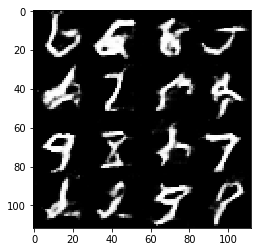

Epoch 2/2... Generator Loss: 0.7897 Discriminator Loss: 1.0427...
Epoch 2/2... Generator Loss: 1.0408 Discriminator Loss: 1.0247...
Epoch 2/2... Generator Loss: 0.9030 Discriminator Loss: 1.1399...
Epoch 2/2... Generator Loss: 0.7893 Discriminator Loss: 1.6089...
Epoch 2/2... Generator Loss: 0.5005 Discriminator Loss: 1.3755...
Epoch 2/2... Generator Loss: 1.0872 Discriminator Loss: 1.2457...
Epoch 2/2... Generator Loss: 1.2914 Discriminator Loss: 1.1369...
Epoch 2/2... Generator Loss: 1.1634 Discriminator Loss: 1.1412...
Epoch 2/2... Generator Loss: 1.1429 Discriminator Loss: 1.0045...
Epoch 2/2... Generator Loss: 0.6373 Discriminator Loss: 1.1456...


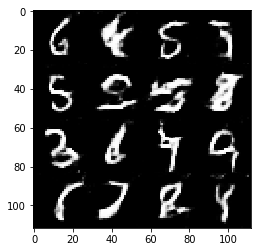

Epoch 2/2... Generator Loss: 1.0045 Discriminator Loss: 1.3268...
Epoch 2/2... Generator Loss: 1.2049 Discriminator Loss: 0.8496...
Epoch 2/2... Generator Loss: 0.9027 Discriminator Loss: 1.2601...
Epoch 2/2... Generator Loss: 1.0524 Discriminator Loss: 0.9580...
Epoch 2/2... Generator Loss: 1.5216 Discriminator Loss: 1.1187...
Epoch 2/2... Generator Loss: 1.2314 Discriminator Loss: 1.0243...
Epoch 2/2... Generator Loss: 0.7255 Discriminator Loss: 1.3264...
Epoch 2/2... Generator Loss: 0.9469 Discriminator Loss: 1.2686...
Epoch 2/2... Generator Loss: 0.8314 Discriminator Loss: 0.9325...
Epoch 2/2... Generator Loss: 1.0727 Discriminator Loss: 0.8614...


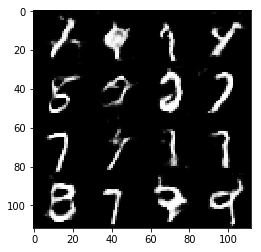

Epoch 2/2... Generator Loss: 1.1039 Discriminator Loss: 1.2470...
Epoch 2/2... Generator Loss: 1.0224 Discriminator Loss: 1.2451...
Epoch 2/2... Generator Loss: 0.9655 Discriminator Loss: 1.3671...
Epoch 2/2... Generator Loss: 1.0721 Discriminator Loss: 1.2751...
Epoch 2/2... Generator Loss: 1.2289 Discriminator Loss: 1.1655...
Epoch 2/2... Generator Loss: 0.9675 Discriminator Loss: 1.3360...
Epoch 2/2... Generator Loss: 1.0253 Discriminator Loss: 1.2118...
Epoch 2/2... Generator Loss: 0.8987 Discriminator Loss: 1.3667...
Epoch 2/2... Generator Loss: 0.9215 Discriminator Loss: 0.9399...
Epoch 2/2... Generator Loss: 1.0958 Discriminator Loss: 1.1717...


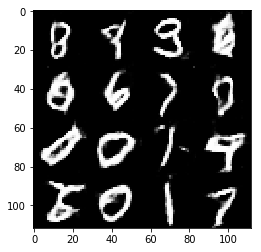

Epoch 2/2... Generator Loss: 1.2174 Discriminator Loss: 1.6956...
Epoch 2/2... Generator Loss: 1.1040 Discriminator Loss: 1.3685...
Epoch 2/2... Generator Loss: 1.0343 Discriminator Loss: 0.9424...
Epoch 2/2... Generator Loss: 1.0938 Discriminator Loss: 1.2061...
Epoch 2/2... Generator Loss: 0.8703 Discriminator Loss: 1.2317...
Epoch 2/2... Generator Loss: 0.8811 Discriminator Loss: 1.2648...
Epoch 2/2... Generator Loss: 1.1116 Discriminator Loss: 1.3833...
Epoch 2/2... Generator Loss: 1.1500 Discriminator Loss: 0.9725...
Epoch 2/2... Generator Loss: 0.7738 Discriminator Loss: 1.0183...
Epoch 2/2... Generator Loss: 0.8988 Discriminator Loss: 1.2331...


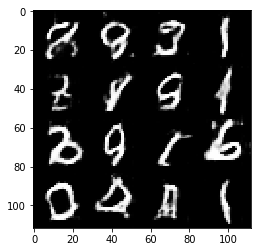

Epoch 2/2... Generator Loss: 1.1227 Discriminator Loss: 1.2015...
Epoch 2/2... Generator Loss: 1.1158 Discriminator Loss: 1.2628...
Epoch 2/2... Generator Loss: 0.8456 Discriminator Loss: 1.1275...
Epoch 2/2... Generator Loss: 1.0314 Discriminator Loss: 1.1699...
Epoch 2/2... Generator Loss: 0.8735 Discriminator Loss: 1.4105...
Epoch 2/2... Generator Loss: 1.2210 Discriminator Loss: 1.2698...
Epoch 2/2... Generator Loss: 1.1460 Discriminator Loss: 1.1243...
Epoch 2/2... Generator Loss: 0.8464 Discriminator Loss: 1.3233...
Epoch 2/2... Generator Loss: 0.7410 Discriminator Loss: 1.5251...
Epoch 2/2... Generator Loss: 0.9193 Discriminator Loss: 0.9569...


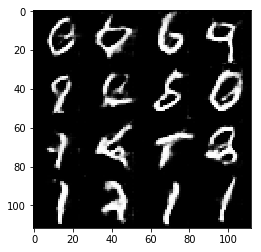

Epoch 2/2... Generator Loss: 1.0176 Discriminator Loss: 1.1192...
Epoch 2/2... Generator Loss: 1.3010 Discriminator Loss: 1.2186...
Epoch 2/2... Generator Loss: 0.9257 Discriminator Loss: 1.1420...
Epoch 2/2... Generator Loss: 1.2014 Discriminator Loss: 1.4045...
Epoch 2/2... Generator Loss: 1.0869 Discriminator Loss: 1.0247...


In [90]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Generator Loss: 7.6437 Discriminator Loss: 0.7228...
Epoch 1/1... Generator Loss: 8.5802 Discriminator Loss: 1.5560...
Epoch 1/1... Generator Loss: 0.1461 Discriminator Loss: 3.1927...
Epoch 1/1... Generator Loss: 5.0058 Discriminator Loss: 0.1300...
Epoch 1/1... Generator Loss: 1.2440 Discriminator Loss: 1.0417...
Epoch 1/1... Generator Loss: 2.4079 Discriminator Loss: 0.6596...
Epoch 1/1... Generator Loss: 3.0402 Discriminator Loss: 0.3451...
Epoch 1/1... Generator Loss: 1.6020 Discriminator Loss: 0.5827...
Epoch 1/1... Generator Loss: 2.8093 Discriminator Loss: 0.7255...
Epoch 1/1... Generator Loss: 0.7843 Discriminator Loss: 1.0164...


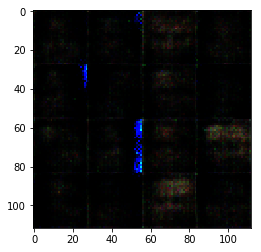

Epoch 1/1... Generator Loss: 2.8374 Discriminator Loss: 1.7403...
Epoch 1/1... Generator Loss: 6.0337 Discriminator Loss: 4.6017...
Epoch 1/1... Generator Loss: 1.3018 Discriminator Loss: 0.7103...
Epoch 1/1... Generator Loss: 0.6970 Discriminator Loss: 1.3498...
Epoch 1/1... Generator Loss: 0.5312 Discriminator Loss: 1.3240...
Epoch 1/1... Generator Loss: 0.8098 Discriminator Loss: 1.2922...
Epoch 1/1... Generator Loss: 1.2054 Discriminator Loss: 0.9740...
Epoch 1/1... Generator Loss: 2.2491 Discriminator Loss: 1.4513...
Epoch 1/1... Generator Loss: 1.0410 Discriminator Loss: 0.7355...
Epoch 1/1... Generator Loss: 0.9127 Discriminator Loss: 1.2292...


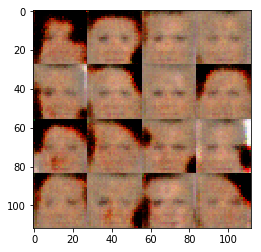

Epoch 1/1... Generator Loss: 0.5365 Discriminator Loss: 1.3834...
Epoch 1/1... Generator Loss: 0.3800 Discriminator Loss: 1.6495...
Epoch 1/1... Generator Loss: 0.2331 Discriminator Loss: 1.7995...
Epoch 1/1... Generator Loss: 1.1187 Discriminator Loss: 0.9195...
Epoch 1/1... Generator Loss: 1.1348 Discriminator Loss: 0.9047...
Epoch 1/1... Generator Loss: 0.9844 Discriminator Loss: 2.3039...
Epoch 1/1... Generator Loss: 1.1005 Discriminator Loss: 0.8671...
Epoch 1/1... Generator Loss: 0.9559 Discriminator Loss: 1.2234...
Epoch 1/1... Generator Loss: 0.6629 Discriminator Loss: 1.1774...
Epoch 1/1... Generator Loss: 1.0231 Discriminator Loss: 0.9001...


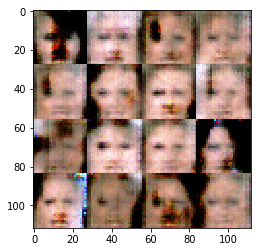

Epoch 1/1... Generator Loss: 0.1371 Discriminator Loss: 2.5142...
Epoch 1/1... Generator Loss: 0.6936 Discriminator Loss: 1.7772...
Epoch 1/1... Generator Loss: 0.8476 Discriminator Loss: 1.3345...
Epoch 1/1... Generator Loss: 1.4296 Discriminator Loss: 1.1509...
Epoch 1/1... Generator Loss: 0.7916 Discriminator Loss: 1.1029...
Epoch 1/1... Generator Loss: 1.3429 Discriminator Loss: 1.2552...
Epoch 1/1... Generator Loss: 0.9879 Discriminator Loss: 1.1271...
Epoch 1/1... Generator Loss: 0.5045 Discriminator Loss: 1.2001...
Epoch 1/1... Generator Loss: 0.3882 Discriminator Loss: 1.6682...
Epoch 1/1... Generator Loss: 2.5231 Discriminator Loss: 2.5519...


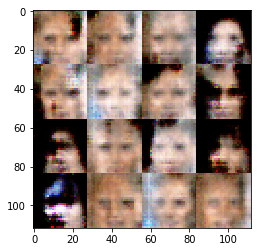

Epoch 1/1... Generator Loss: 0.8348 Discriminator Loss: 1.0579...
Epoch 1/1... Generator Loss: 1.0692 Discriminator Loss: 1.1065...
Epoch 1/1... Generator Loss: 0.5773 Discriminator Loss: 1.2888...
Epoch 1/1... Generator Loss: 0.6540 Discriminator Loss: 1.1156...
Epoch 1/1... Generator Loss: 0.6372 Discriminator Loss: 1.4630...
Epoch 1/1... Generator Loss: 0.9184 Discriminator Loss: 0.8680...
Epoch 1/1... Generator Loss: 0.8529 Discriminator Loss: 1.3086...
Epoch 1/1... Generator Loss: 1.0211 Discriminator Loss: 1.2385...
Epoch 1/1... Generator Loss: 1.2128 Discriminator Loss: 1.1106...
Epoch 1/1... Generator Loss: 1.3894 Discriminator Loss: 1.2398...


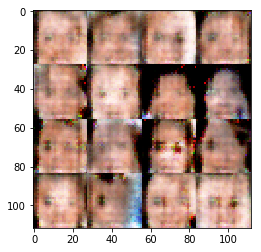

Epoch 1/1... Generator Loss: 0.8650 Discriminator Loss: 0.8796...
Epoch 1/1... Generator Loss: 0.5461 Discriminator Loss: 1.5578...
Epoch 1/1... Generator Loss: 1.1412 Discriminator Loss: 1.0935...
Epoch 1/1... Generator Loss: 1.0059 Discriminator Loss: 1.3096...
Epoch 1/1... Generator Loss: 1.4919 Discriminator Loss: 0.9458...
Epoch 1/1... Generator Loss: 0.9686 Discriminator Loss: 1.2236...
Epoch 1/1... Generator Loss: 1.4827 Discriminator Loss: 1.7828...
Epoch 1/1... Generator Loss: 0.7456 Discriminator Loss: 1.0109...
Epoch 1/1... Generator Loss: 1.3261 Discriminator Loss: 1.2093...
Epoch 1/1... Generator Loss: 0.8255 Discriminator Loss: 1.1279...


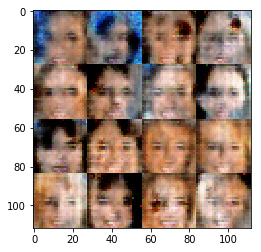

Epoch 1/1... Generator Loss: 0.4078 Discriminator Loss: 1.5685...
Epoch 1/1... Generator Loss: 0.9558 Discriminator Loss: 1.0346...
Epoch 1/1... Generator Loss: 0.4645 Discriminator Loss: 1.4210...
Epoch 1/1... Generator Loss: 0.8364 Discriminator Loss: 1.2308...
Epoch 1/1... Generator Loss: 1.0820 Discriminator Loss: 1.2657...
Epoch 1/1... Generator Loss: 0.8343 Discriminator Loss: 1.2034...
Epoch 1/1... Generator Loss: 1.0182 Discriminator Loss: 1.1446...
Epoch 1/1... Generator Loss: 0.9405 Discriminator Loss: 1.4461...
Epoch 1/1... Generator Loss: 0.5894 Discriminator Loss: 1.5973...
Epoch 1/1... Generator Loss: 0.7558 Discriminator Loss: 1.1519...


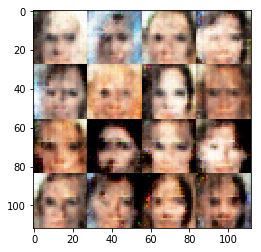

Epoch 1/1... Generator Loss: 0.6291 Discriminator Loss: 1.2313...
Epoch 1/1... Generator Loss: 1.0476 Discriminator Loss: 1.2713...
Epoch 1/1... Generator Loss: 0.8527 Discriminator Loss: 1.3148...
Epoch 1/1... Generator Loss: 0.7423 Discriminator Loss: 1.2804...
Epoch 1/1... Generator Loss: 0.6311 Discriminator Loss: 1.3529...
Epoch 1/1... Generator Loss: 0.6077 Discriminator Loss: 1.2654...
Epoch 1/1... Generator Loss: 0.7339 Discriminator Loss: 1.1318...
Epoch 1/1... Generator Loss: 1.1881 Discriminator Loss: 1.4828...
Epoch 1/1... Generator Loss: 1.0073 Discriminator Loss: 1.4487...
Epoch 1/1... Generator Loss: 0.4624 Discriminator Loss: 1.3472...


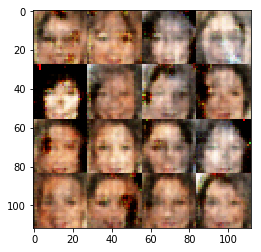

Epoch 1/1... Generator Loss: 1.3194 Discriminator Loss: 1.2816...
Epoch 1/1... Generator Loss: 0.7917 Discriminator Loss: 1.1877...
Epoch 1/1... Generator Loss: 0.7171 Discriminator Loss: 1.4440...
Epoch 1/1... Generator Loss: 1.2535 Discriminator Loss: 1.2323...
Epoch 1/1... Generator Loss: 0.3593 Discriminator Loss: 1.5926...
Epoch 1/1... Generator Loss: 0.7784 Discriminator Loss: 1.4313...
Epoch 1/1... Generator Loss: 0.7777 Discriminator Loss: 1.1111...
Epoch 1/1... Generator Loss: 1.2807 Discriminator Loss: 1.3216...
Epoch 1/1... Generator Loss: 0.3089 Discriminator Loss: 1.6167...
Epoch 1/1... Generator Loss: 1.0691 Discriminator Loss: 1.3444...


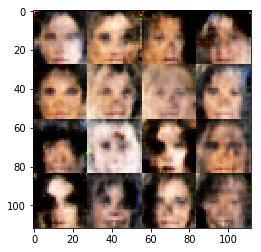

Epoch 1/1... Generator Loss: 0.7030 Discriminator Loss: 1.3158...
Epoch 1/1... Generator Loss: 0.6958 Discriminator Loss: 1.3891...
Epoch 1/1... Generator Loss: 0.9927 Discriminator Loss: 1.5238...
Epoch 1/1... Generator Loss: 0.5307 Discriminator Loss: 1.2038...
Epoch 1/1... Generator Loss: 0.6234 Discriminator Loss: 1.4180...
Epoch 1/1... Generator Loss: 0.5737 Discriminator Loss: 1.3581...
Epoch 1/1... Generator Loss: 0.6147 Discriminator Loss: 1.3463...
Epoch 1/1... Generator Loss: 0.8955 Discriminator Loss: 1.1549...
Epoch 1/1... Generator Loss: 0.6875 Discriminator Loss: 1.2267...
Epoch 1/1... Generator Loss: 0.8063 Discriminator Loss: 1.2046...


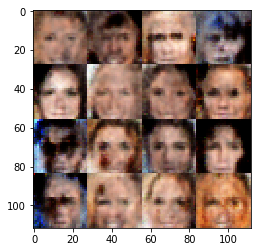

Epoch 1/1... Generator Loss: 0.9622 Discriminator Loss: 1.3113...
Epoch 1/1... Generator Loss: 0.6694 Discriminator Loss: 1.2096...
Epoch 1/1... Generator Loss: 0.8726 Discriminator Loss: 1.3737...
Epoch 1/1... Generator Loss: 0.6064 Discriminator Loss: 1.2601...
Epoch 1/1... Generator Loss: 0.6805 Discriminator Loss: 1.2845...
Epoch 1/1... Generator Loss: 0.7810 Discriminator Loss: 1.3904...
Epoch 1/1... Generator Loss: 0.7354 Discriminator Loss: 1.2715...
Epoch 1/1... Generator Loss: 1.1809 Discriminator Loss: 1.4555...
Epoch 1/1... Generator Loss: 0.7155 Discriminator Loss: 1.2602...
Epoch 1/1... Generator Loss: 0.6017 Discriminator Loss: 1.1512...


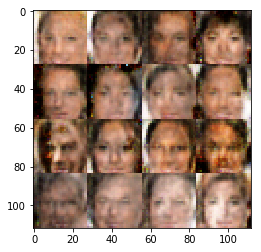

Epoch 1/1... Generator Loss: 0.6264 Discriminator Loss: 1.2956...
Epoch 1/1... Generator Loss: 0.9700 Discriminator Loss: 1.3501...
Epoch 1/1... Generator Loss: 0.7753 Discriminator Loss: 1.3364...
Epoch 1/1... Generator Loss: 0.5791 Discriminator Loss: 1.2973...
Epoch 1/1... Generator Loss: 1.0389 Discriminator Loss: 1.4114...
Epoch 1/1... Generator Loss: 0.7872 Discriminator Loss: 1.3326...
Epoch 1/1... Generator Loss: 0.7911 Discriminator Loss: 1.4160...
Epoch 1/1... Generator Loss: 0.7418 Discriminator Loss: 1.3952...
Epoch 1/1... Generator Loss: 0.6994 Discriminator Loss: 1.3096...
Epoch 1/1... Generator Loss: 0.4665 Discriminator Loss: 1.3935...


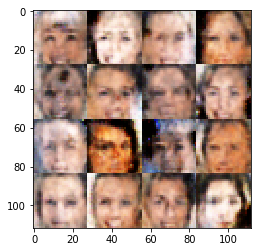

Epoch 1/1... Generator Loss: 0.9646 Discriminator Loss: 1.4741...
Epoch 1/1... Generator Loss: 0.6683 Discriminator Loss: 1.4419...
Epoch 1/1... Generator Loss: 0.6871 Discriminator Loss: 1.1521...
Epoch 1/1... Generator Loss: 0.6402 Discriminator Loss: 1.4472...
Epoch 1/1... Generator Loss: 0.6634 Discriminator Loss: 1.2472...
Epoch 1/1... Generator Loss: 0.8873 Discriminator Loss: 1.3469...
Epoch 1/1... Generator Loss: 0.8776 Discriminator Loss: 1.3506...
Epoch 1/1... Generator Loss: 0.8740 Discriminator Loss: 1.3809...
Epoch 1/1... Generator Loss: 1.0967 Discriminator Loss: 1.5662...
Epoch 1/1... Generator Loss: 0.5456 Discriminator Loss: 1.3747...


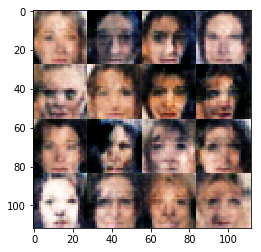

Epoch 1/1... Generator Loss: 0.6890 Discriminator Loss: 1.4068...
Epoch 1/1... Generator Loss: 0.6094 Discriminator Loss: 1.3993...
Epoch 1/1... Generator Loss: 0.6138 Discriminator Loss: 1.2005...
Epoch 1/1... Generator Loss: 0.6278 Discriminator Loss: 1.3271...
Epoch 1/1... Generator Loss: 0.5908 Discriminator Loss: 1.4641...
Epoch 1/1... Generator Loss: 0.4426 Discriminator Loss: 1.4141...
Epoch 1/1... Generator Loss: 0.8182 Discriminator Loss: 1.2619...
Epoch 1/1... Generator Loss: 0.6922 Discriminator Loss: 1.2637...
Epoch 1/1... Generator Loss: 0.7667 Discriminator Loss: 1.3421...
Epoch 1/1... Generator Loss: 0.6478 Discriminator Loss: 1.3623...


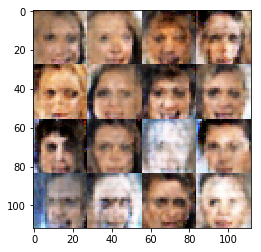

Epoch 1/1... Generator Loss: 0.6055 Discriminator Loss: 1.2530...
Epoch 1/1... Generator Loss: 0.7319 Discriminator Loss: 1.4153...
Epoch 1/1... Generator Loss: 0.7613 Discriminator Loss: 1.4049...
Epoch 1/1... Generator Loss: 0.7693 Discriminator Loss: 1.4336...
Epoch 1/1... Generator Loss: 0.6939 Discriminator Loss: 1.3470...
Epoch 1/1... Generator Loss: 0.9553 Discriminator Loss: 1.3404...
Epoch 1/1... Generator Loss: 0.7836 Discriminator Loss: 1.2379...
Epoch 1/1... Generator Loss: 0.7638 Discriminator Loss: 1.4417...
Epoch 1/1... Generator Loss: 0.8935 Discriminator Loss: 1.4489...
Epoch 1/1... Generator Loss: 0.9257 Discriminator Loss: 1.2457...


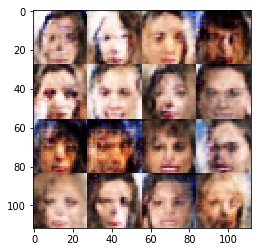

Epoch 1/1... Generator Loss: 0.5851 Discriminator Loss: 1.3028...
Epoch 1/1... Generator Loss: 1.0947 Discriminator Loss: 1.4290...
Epoch 1/1... Generator Loss: 0.6777 Discriminator Loss: 1.5157...
Epoch 1/1... Generator Loss: 0.5868 Discriminator Loss: 1.2716...
Epoch 1/1... Generator Loss: 0.7643 Discriminator Loss: 1.4128...
Epoch 1/1... Generator Loss: 0.7925 Discriminator Loss: 1.4242...
Epoch 1/1... Generator Loss: 0.5263 Discriminator Loss: 1.3219...
Epoch 1/1... Generator Loss: 0.8637 Discriminator Loss: 1.4140...
Epoch 1/1... Generator Loss: 0.7530 Discriminator Loss: 1.3249...
Epoch 1/1... Generator Loss: 0.5092 Discriminator Loss: 1.3643...


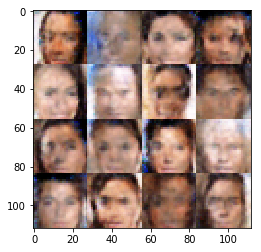

Epoch 1/1... Generator Loss: 0.8513 Discriminator Loss: 1.3705...
Epoch 1/1... Generator Loss: 0.6856 Discriminator Loss: 1.3670...
Epoch 1/1... Generator Loss: 0.6417 Discriminator Loss: 1.2069...
Epoch 1/1... Generator Loss: 0.6757 Discriminator Loss: 1.3887...
Epoch 1/1... Generator Loss: 0.6822 Discriminator Loss: 1.3548...
Epoch 1/1... Generator Loss: 0.5638 Discriminator Loss: 1.2451...
Epoch 1/1... Generator Loss: 0.9188 Discriminator Loss: 1.3680...
Epoch 1/1... Generator Loss: 0.6578 Discriminator Loss: 1.3814...
Epoch 1/1... Generator Loss: 0.8249 Discriminator Loss: 1.3530...
Epoch 1/1... Generator Loss: 0.5647 Discriminator Loss: 1.1434...


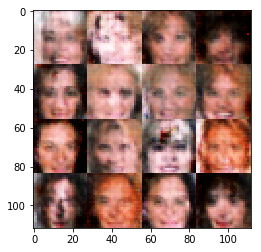

Epoch 1/1... Generator Loss: 0.7909 Discriminator Loss: 1.3269...
Epoch 1/1... Generator Loss: 0.8143 Discriminator Loss: 1.4238...
Epoch 1/1... Generator Loss: 0.6655 Discriminator Loss: 1.3658...
Epoch 1/1... Generator Loss: 0.9146 Discriminator Loss: 1.4114...
Epoch 1/1... Generator Loss: 0.6502 Discriminator Loss: 1.3441...
Epoch 1/1... Generator Loss: 0.6799 Discriminator Loss: 1.3090...
Epoch 1/1... Generator Loss: 0.5304 Discriminator Loss: 1.4117...
Epoch 1/1... Generator Loss: 0.7989 Discriminator Loss: 1.3913...
Epoch 1/1... Generator Loss: 0.6989 Discriminator Loss: 1.4936...
Epoch 1/1... Generator Loss: 0.7562 Discriminator Loss: 1.3211...


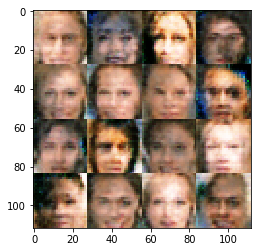

Epoch 1/1... Generator Loss: 0.7098 Discriminator Loss: 1.3488...
Epoch 1/1... Generator Loss: 0.8405 Discriminator Loss: 1.3678...
Epoch 1/1... Generator Loss: 0.6480 Discriminator Loss: 1.3883...
Epoch 1/1... Generator Loss: 0.7174 Discriminator Loss: 1.1778...
Epoch 1/1... Generator Loss: 0.5853 Discriminator Loss: 1.3876...
Epoch 1/1... Generator Loss: 0.5654 Discriminator Loss: 1.4139...
Epoch 1/1... Generator Loss: 0.9848 Discriminator Loss: 1.4264...
Epoch 1/1... Generator Loss: 0.7164 Discriminator Loss: 1.3885...
Epoch 1/1... Generator Loss: 0.6856 Discriminator Loss: 1.3335...
Epoch 1/1... Generator Loss: 0.6490 Discriminator Loss: 1.3359...


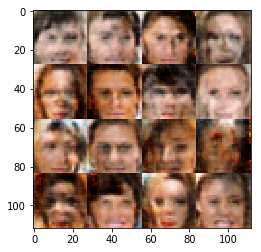

Epoch 1/1... Generator Loss: 0.8541 Discriminator Loss: 1.3687...
Epoch 1/1... Generator Loss: 0.6350 Discriminator Loss: 1.3277...
Epoch 1/1... Generator Loss: 0.8032 Discriminator Loss: 1.2551...
Epoch 1/1... Generator Loss: 0.7749 Discriminator Loss: 1.2582...
Epoch 1/1... Generator Loss: 0.7357 Discriminator Loss: 1.3472...
Epoch 1/1... Generator Loss: 0.6327 Discriminator Loss: 1.4034...
Epoch 1/1... Generator Loss: 0.6821 Discriminator Loss: 1.4102...
Epoch 1/1... Generator Loss: 0.7413 Discriminator Loss: 1.2711...
Epoch 1/1... Generator Loss: 0.5726 Discriminator Loss: 1.4859...
Epoch 1/1... Generator Loss: 0.7967 Discriminator Loss: 1.4554...


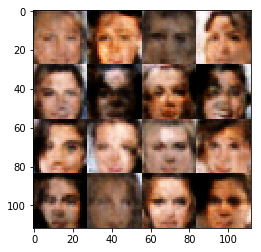

Epoch 1/1... Generator Loss: 0.8064 Discriminator Loss: 1.4068...
Epoch 1/1... Generator Loss: 0.6634 Discriminator Loss: 1.2932...
Epoch 1/1... Generator Loss: 0.7732 Discriminator Loss: 1.4365...
Epoch 1/1... Generator Loss: 0.8548 Discriminator Loss: 1.4581...
Epoch 1/1... Generator Loss: 0.5486 Discriminator Loss: 1.2482...
Epoch 1/1... Generator Loss: 0.6606 Discriminator Loss: 1.5392...
Epoch 1/1... Generator Loss: 0.6387 Discriminator Loss: 1.3717...
Epoch 1/1... Generator Loss: 0.5417 Discriminator Loss: 1.4013...
Epoch 1/1... Generator Loss: 0.7949 Discriminator Loss: 1.4045...
Epoch 1/1... Generator Loss: 0.8603 Discriminator Loss: 1.3186...


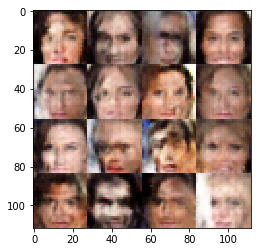

Epoch 1/1... Generator Loss: 0.5805 Discriminator Loss: 1.3649...
Epoch 1/1... Generator Loss: 0.8066 Discriminator Loss: 1.4388...
Epoch 1/1... Generator Loss: 0.7604 Discriminator Loss: 1.3498...
Epoch 1/1... Generator Loss: 0.5846 Discriminator Loss: 1.4231...
Epoch 1/1... Generator Loss: 1.1265 Discriminator Loss: 1.2796...
Epoch 1/1... Generator Loss: 0.6910 Discriminator Loss: 1.4003...
Epoch 1/1... Generator Loss: 0.7613 Discriminator Loss: 1.4287...
Epoch 1/1... Generator Loss: 0.7606 Discriminator Loss: 1.4049...
Epoch 1/1... Generator Loss: 0.8107 Discriminator Loss: 1.3590...
Epoch 1/1... Generator Loss: 0.5575 Discriminator Loss: 1.4921...


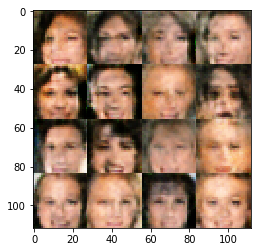

Epoch 1/1... Generator Loss: 0.7863 Discriminator Loss: 1.4235...
Epoch 1/1... Generator Loss: 0.6992 Discriminator Loss: 1.3980...
Epoch 1/1... Generator Loss: 0.7688 Discriminator Loss: 1.3335...
Epoch 1/1... Generator Loss: 0.7086 Discriminator Loss: 1.3167...
Epoch 1/1... Generator Loss: 0.7802 Discriminator Loss: 1.3682...
Epoch 1/1... Generator Loss: 0.8109 Discriminator Loss: 1.3693...
Epoch 1/1... Generator Loss: 1.0146 Discriminator Loss: 1.2946...
Epoch 1/1... Generator Loss: 0.6636 Discriminator Loss: 1.3325...
Epoch 1/1... Generator Loss: 0.6085 Discriminator Loss: 1.3784...
Epoch 1/1... Generator Loss: 0.8900 Discriminator Loss: 1.4287...


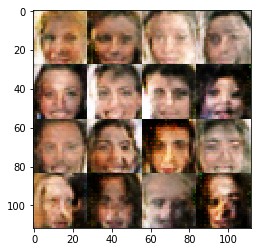

Epoch 1/1... Generator Loss: 0.6314 Discriminator Loss: 1.4064...
Epoch 1/1... Generator Loss: 0.6423 Discriminator Loss: 1.4926...
Epoch 1/1... Generator Loss: 0.7466 Discriminator Loss: 1.4072...
Epoch 1/1... Generator Loss: 0.8490 Discriminator Loss: 1.3875...
Epoch 1/1... Generator Loss: 0.6412 Discriminator Loss: 1.4128...
Epoch 1/1... Generator Loss: 0.8125 Discriminator Loss: 1.3382...
Epoch 1/1... Generator Loss: 0.7735 Discriminator Loss: 1.4759...
Epoch 1/1... Generator Loss: 0.7381 Discriminator Loss: 1.2518...
Epoch 1/1... Generator Loss: 0.5288 Discriminator Loss: 1.3812...
Epoch 1/1... Generator Loss: 0.5713 Discriminator Loss: 1.5573...


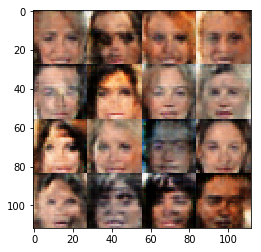

Epoch 1/1... Generator Loss: 0.6484 Discriminator Loss: 1.3939...
Epoch 1/1... Generator Loss: 0.6741 Discriminator Loss: 1.3454...
Epoch 1/1... Generator Loss: 0.6700 Discriminator Loss: 1.3358...
Epoch 1/1... Generator Loss: 0.8526 Discriminator Loss: 1.4458...
Epoch 1/1... Generator Loss: 0.6295 Discriminator Loss: 1.3613...
Epoch 1/1... Generator Loss: 0.6218 Discriminator Loss: 1.2730...
Epoch 1/1... Generator Loss: 0.6861 Discriminator Loss: 1.3656...
Epoch 1/1... Generator Loss: 0.6348 Discriminator Loss: 1.3691...
Epoch 1/1... Generator Loss: 0.9331 Discriminator Loss: 1.3016...
Epoch 1/1... Generator Loss: 0.7790 Discriminator Loss: 1.3502...


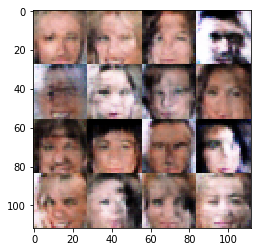

Epoch 1/1... Generator Loss: 0.5492 Discriminator Loss: 1.3847...
Epoch 1/1... Generator Loss: 0.6866 Discriminator Loss: 1.3517...
Epoch 1/1... Generator Loss: 0.7560 Discriminator Loss: 1.3863...
Epoch 1/1... Generator Loss: 0.5892 Discriminator Loss: 1.2703...
Epoch 1/1... Generator Loss: 0.7384 Discriminator Loss: 1.3735...
Epoch 1/1... Generator Loss: 0.8072 Discriminator Loss: 1.3075...
Epoch 1/1... Generator Loss: 1.0055 Discriminator Loss: 1.4590...
Epoch 1/1... Generator Loss: 0.8945 Discriminator Loss: 1.4248...
Epoch 1/1... Generator Loss: 0.6086 Discriminator Loss: 1.3281...
Epoch 1/1... Generator Loss: 0.8466 Discriminator Loss: 1.3187...


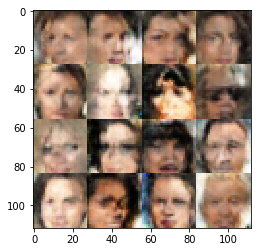

Epoch 1/1... Generator Loss: 0.8651 Discriminator Loss: 1.4013...
Epoch 1/1... Generator Loss: 0.6473 Discriminator Loss: 1.4004...
Epoch 1/1... Generator Loss: 0.7171 Discriminator Loss: 1.4058...
Epoch 1/1... Generator Loss: 0.7413 Discriminator Loss: 1.4021...
Epoch 1/1... Generator Loss: 0.8381 Discriminator Loss: 1.3917...
Epoch 1/1... Generator Loss: 0.7894 Discriminator Loss: 1.3318...
Epoch 1/1... Generator Loss: 0.8020 Discriminator Loss: 1.3974...
Epoch 1/1... Generator Loss: 0.9372 Discriminator Loss: 1.3950...
Epoch 1/1... Generator Loss: 0.8814 Discriminator Loss: 1.4196...
Epoch 1/1... Generator Loss: 0.6713 Discriminator Loss: 1.4120...


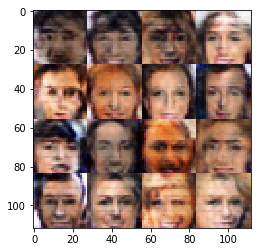

Epoch 1/1... Generator Loss: 0.4810 Discriminator Loss: 1.5176...
Epoch 1/1... Generator Loss: 0.6112 Discriminator Loss: 1.4197...
Epoch 1/1... Generator Loss: 0.6117 Discriminator Loss: 1.2653...
Epoch 1/1... Generator Loss: 0.6803 Discriminator Loss: 1.4133...
Epoch 1/1... Generator Loss: 0.6652 Discriminator Loss: 1.4346...
Epoch 1/1... Generator Loss: 0.8028 Discriminator Loss: 1.4501...
Epoch 1/1... Generator Loss: 0.7578 Discriminator Loss: 1.3643...
Epoch 1/1... Generator Loss: 0.7297 Discriminator Loss: 1.3789...
Epoch 1/1... Generator Loss: 0.6638 Discriminator Loss: 1.3875...
Epoch 1/1... Generator Loss: 0.7031 Discriminator Loss: 1.4040...


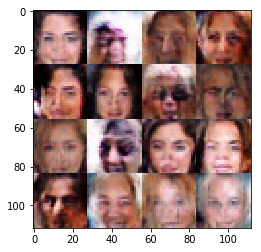

Epoch 1/1... Generator Loss: 0.6534 Discriminator Loss: 1.4417...
Epoch 1/1... Generator Loss: 0.7439 Discriminator Loss: 1.3712...
Epoch 1/1... Generator Loss: 0.5998 Discriminator Loss: 1.3503...
Epoch 1/1... Generator Loss: 0.6589 Discriminator Loss: 1.3948...
Epoch 1/1... Generator Loss: 0.7607 Discriminator Loss: 1.3734...
Epoch 1/1... Generator Loss: 0.7687 Discriminator Loss: 1.3815...
Epoch 1/1... Generator Loss: 0.5052 Discriminator Loss: 1.3305...
Epoch 1/1... Generator Loss: 0.8073 Discriminator Loss: 1.3096...
Epoch 1/1... Generator Loss: 0.8031 Discriminator Loss: 1.3265...
Epoch 1/1... Generator Loss: 0.5803 Discriminator Loss: 1.3721...


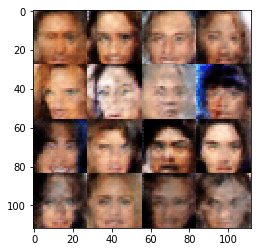

Epoch 1/1... Generator Loss: 0.7179 Discriminator Loss: 1.3926...
Epoch 1/1... Generator Loss: 0.6733 Discriminator Loss: 1.4067...
Epoch 1/1... Generator Loss: 0.7713 Discriminator Loss: 1.3829...
Epoch 1/1... Generator Loss: 0.8415 Discriminator Loss: 1.3606...
Epoch 1/1... Generator Loss: 0.8014 Discriminator Loss: 1.4640...
Epoch 1/1... Generator Loss: 0.7189 Discriminator Loss: 1.3622...
Epoch 1/1... Generator Loss: 0.4982 Discriminator Loss: 1.5491...
Epoch 1/1... Generator Loss: 0.6392 Discriminator Loss: 1.3049...
Epoch 1/1... Generator Loss: 0.7140 Discriminator Loss: 1.3507...
Epoch 1/1... Generator Loss: 0.7372 Discriminator Loss: 1.3271...


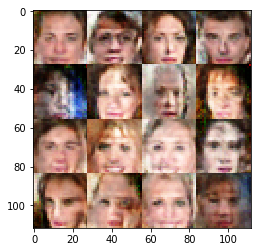

Epoch 1/1... Generator Loss: 0.7667 Discriminator Loss: 1.3469...
Epoch 1/1... Generator Loss: 0.6573 Discriminator Loss: 1.3880...
Epoch 1/1... Generator Loss: 0.8404 Discriminator Loss: 1.3333...
Epoch 1/1... Generator Loss: 0.6531 Discriminator Loss: 1.4941...
Epoch 1/1... Generator Loss: 0.7774 Discriminator Loss: 1.3836...
Epoch 1/1... Generator Loss: 0.7445 Discriminator Loss: 1.4154...
Epoch 1/1... Generator Loss: 0.5727 Discriminator Loss: 1.1599...
Epoch 1/1... Generator Loss: 0.6276 Discriminator Loss: 1.4256...
Epoch 1/1... Generator Loss: 0.7256 Discriminator Loss: 1.3969...
Epoch 1/1... Generator Loss: 0.6834 Discriminator Loss: 1.3391...


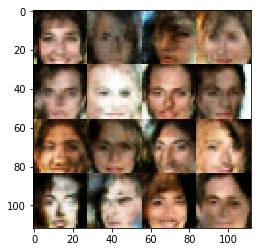

Epoch 1/1... Generator Loss: 0.7473 Discriminator Loss: 1.4083...
Epoch 1/1... Generator Loss: 0.7050 Discriminator Loss: 1.3872...
Epoch 1/1... Generator Loss: 0.6257 Discriminator Loss: 1.3775...
Epoch 1/1... Generator Loss: 0.6450 Discriminator Loss: 1.2719...
Epoch 1/1... Generator Loss: 0.6453 Discriminator Loss: 1.3199...
Epoch 1/1... Generator Loss: 0.7420 Discriminator Loss: 1.3948...


In [91]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.